In [ ]:
### To-Do
# 0) work out math if extra treatment needed for lumi normalization
# 1) plot some variables before and after normalization. how do they compare?
# 2) try batch normalization in the network? re-do step1 maybe?
# 3) to_categorical for signal and background preds?
# 4) grid optimization? --> dropout rate, layers, nodes, etc
# 5) k-fold optimization?

In [63]:
# Import the needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.utils import normalize, to_categorical
from sklearn.model_selection import train_test_split

In [2]:
hh_xsec = 12.36 # fb
qcd_xsec = 441866.0 # fb

hh_effLumi = 33034 # fb-1
qcd_effLumi = 1.36 # fb-1
totalLumi_HLLHC = 3000 # fb-1

#L = N/sig --> L_qcd / L_hh is the lumi-scale we need
lumiScale_hh_to_qcd = qcd_effLumi/hh_effLumi
print(lumiScale_hh_to_qcd)

4.116970394139372e-05


In [3]:
def makeEqualSamplesWithUserVariables(signal_raw, bkg_raw, userVariables, nEventsForXGB):
    """function to return 4 dataframes containing user-specified variables and number of events: 1 signal for training, 1 bkg for training, 1 signal for plotting, 1 bkg for plotting"""
    
    # *** 0. Reduce dataframes to only desired variables
    signal_reduced  = signal_raw[userVariables]
    bkg_reduced     = bkg_raw[userVariables]
    signal_labels   = signal_raw[ ['isSignal'] ]
    bkg_labels      = bkg_raw[ ['isSignal'] ]

    # *** 1. Take first nEventsForXGB events for passing to XGB 
    signal_reducedForXGB  = signal_reduced[:nEventsForXGB]
    bkg_reducedForXGB     = bkg_reduced[:nEventsForXGB]
    signal_labelsForXGB   = signal_labels[:nEventsForXGB]
    bkg_labelsForXGB      = bkg_labels[:nEventsForXGB]

    # *** 2. Combine bkg+signal for passing to XGB 
    all_reducedForXGB  = signal_reducedForXGB.append(bkg_reducedForXGB)
    all_labelsForXGB   = signal_labelsForXGB.append(bkg_labelsForXGB)

    
    # ** 3. Use additional events for unambiguous testing 
    signal_reducedForPlots  = signal_reduced[nEventsForXGB:len(bkg_reduced)]
    bkg_reducedForPlots     = bkg_reduced[nEventsForXGB:len(bkg_reduced)]
    signal_labelsForPlots   = signal_labels[nEventsForXGB:len(bkg_reduced)]
    bkg_labelsForPlots      = bkg_labels[nEventsForXGB:len(bkg_reduced)]

    # *** 4. Sanity check
    print(len(all_reducedForXGB), 'rows of data with ', len(all_labelsForXGB), 'labels [XGB]')
    print(len(signal_reducedForPlots), 'rows of signal data with ', len(bkg_labelsForPlots), 'rows of background [Plots]')

    
    return all_reducedForXGB, all_labelsForXGB, signal_reducedForPlots, signal_labelsForPlots, bkg_reducedForPlots, bkg_labelsForPlots


def makeTestTrainSamplesWithUserVariables(signal_raw, bkg_raw, userVariables, _fractionEventsForTesting):
    """function to return 4 dataframes containing user-specified variables and number of events: 1 mixed signal+background for training, 1 mixed signal+background for testing"""
    
    # *** 0. Reduce dataframes to only desired variables
    signal_reduced  = signal_raw[userVariables]
    bkg_reduced     = bkg_raw[userVariables]
    signal_labels   = signal_raw[ ['isSignal'] ]
    bkg_labels      = bkg_raw[ ['isSignal'] ]

    # *** 1. Make equal-sized samples
    nTotalEvents = min( len(signal_reduced), len(bkg_reduced))
    print(nTotalEvents, len(signal_reduced), len(bkg_reduced))
    
    signal_reducedForSplit  = signal_reduced[:nTotalEvents]
    bkg_reducedForSplit     = bkg_reduced[:nTotalEvents]
    signal_labelsForSplit   = signal_labels[:nTotalEvents]
    bkg_labelsForSplit       = bkg_labels[:nTotalEvents]

    # *** 2. Combine bkg+signal for passing to XGB 
    all_dataForSplit  = signal_reducedForSplit.append(bkg_reducedForSplit)
    all_labelsForSplit   = signal_labelsForSplit.append(bkg_labelsForSplit)


    # *** 3. Make test/train split
    data_train, data_test, labels_train, labels_test = train_test_split(all_dataForSplit, all_labelsForSplit, test_size=_fractionEventsForTesting, shuffle= True)
    
    # *** 3. Sanity check
    print(len(all_dataForSplit), 'rows of total data with ', len(all_labelsForSplit), 'labels [Train+Test]')
    print(len(data_train), 'rows of training data with ', len(labels_train), 'labels [Train]')
    print(len(data_test), 'rows of testing data with ', len(labels_test), 'labels [Test]')
    
    
    return data_train, data_test, labels_train, labels_test


In [4]:
def compareManyHistograms( _dict, _labels, _nPlot, _title, _xtitle, _xMin, _xMax, _nBins, _normed=False, _savePlot=False):
       
    if len(_dict.keys()) < len(_labels):
        print ("!!! Unequal number of arrays and labels. Learn to count better.")
        return 0
    
    plt.figure(_nPlot)
    if _normed:
        plt.title(_title + ' (Normalized)')
    else:
        plt.title(_title)
    plt.xlabel(_xtitle)
    plt.ylabel('N_events')
    _bins = np.linspace(_xMin, _xMax, _nBins)
   
    y_max = 0
    for iLabel in _labels:
        plt.hist(_dict[iLabel], _bins, alpha=0.5, density=_normed, label= iLabel+' Events')
        
        # get values of histgoram to find greatest y
        #_y, _x, _ = plt.hist(_dict[iLabel])
        #if (_y.max() > y_max):
        #    y_max = _y.max()
    
    # set max y-value of histogram so there's room for legend
    axes = plt.gca()
    axes.set_ylim([0,4000])
    #plt.ylim([0,1.2*y_max])
    
    #draw legend
    plt.legend(loc='upper left')
    #plt.text(.1, .1, s1)
    
    # store figure copy for later saving
    fig = plt.gcf()
    
    # draw interactively
    plt.show()
    
    #save an image file
    if(_savePlot):
        _scope    = _title.split(' ')[0].lower()
        _variable = _xtitle.lstrip('Jet Pair').replace(' ','').replace('[GeV]','').replace('(','_').replace(')','')
        _filename  = _scope + '_' + _variable
        if _normed:
            _filename = _filename + '_norm'
        fig.savefig( _filename+'.png', bbox_inches='tight' )
    
    
    return


def returnBestCutValue( _variable, _signal, _background, _method='S/sqrt(B)', _minBackground=500):
    """find best cut according to user-specified significance metric"""
    
    _bestSignificance = -1
    _bestCutValue = -1
    _massWidth = 30 #GeV
    _nTotalSignal =len(_signal) 
    _nTotalBackground =len(_background) 
    _cuts = []
    _sortedSignal = np.sort(_signal )
    _sortedBackground = np.sort(_background )

    print(_nTotalSignal, _nTotalBackground)
    _minVal = min( min(_sortedSignal), min(_sortedBackground) )
    _maxVal = max( max(_sortedSignal), max(_sortedBackground) )
    
    if 'mass' in _variable:
        _stepSize = 0.05 if 'mass' not in _variable else 5
        _cuts = list(range(_minVal, _maxVal, _stepSize))
    else:
        _cuts = np.linspace(_minVal, _maxVal, 100)
    
    #print(_minVal, _maxVal)

    for iCutValue in _cuts:
        _nSignal = sum( value > iCutValue for value in _signal)*lumiScale_hh_to_qcd*totalLumi_HLLHC
        _nBackground = sum( value > iCutValue for value in _background)*totalLumi_HLLHC
        
        # safety check to avoid division by 0
        if _nBackground < _minBackground: # 500 is semi-random choice.. it's where one series started to oscillate
            #print("continued on {0}".format(iCutValue))
            continue
        
        #if _method == 'S/sqrt(B)':
        #    print(_nSignal, _nBackground, iCutValue, (_nSignal / np.sqrt(_nBackground)), (_nSignal / np.sqrt(_nSignal + _nBackground)))
        
        if _method == 'S/B' and (_nSignal / _nBackground) > _bestSignificance:
            _bestSignificance = (_nSignal / _nBackground)
            _bestCutValue = iCutValue
        elif _method == 'S/sqrt(B)' and (_nSignal / np.sqrt(_nBackground)) > _bestSignificance:
            _bestSignificance = (_nSignal / np.sqrt(_nBackground))
            _bestCutValue = iCutValue
        elif _method == 'S/sqrt(S+B)' and (_nSignal / np.sqrt(_nSignal + _nBackground)) > _bestSignificance:
            _bestSignificance = (_nSignal / np.sqrt(_nSignal + _nBackground))
            _bestCutValue = iCutValue
                
        #print(iCutValue, _nSignal, _nBackground, (_nSignal / np.sqrt(_nBackground)))

    _nSignal = sum( value > _bestCutValue for value in _signal)*lumiScale_hh_to_qcd*totalLumi_HLLHC
    _nBackground = sum( value > _bestCutValue for value in _background)*totalLumi_HLLHC
    #print(_nSignal, _nBackground, _nSignal/np.sqrt(_nBackground), _bestCutValue)
    print('nSig = {0} , nBkg = {1} with significance = {2} for {3} score > {4}'.format(_nSignal, _nBackground, _nSignal/np.sqrt(_nBackground), _variable, _bestCutValue) )
          
    return _bestSignificance, _bestCutValue

In [48]:
#*** 1. Import data and check stuff
# *** A. Import Dataset
qcd_raw = pd.read_csv('../samples_500k/qcd_outputDataForLearning.csv')
qcd_raw['isSignal'] = 0
hh_raw = pd.read_csv('../samples_500k/dihiggs_outputDataForLearning.csv')
hh_raw['isSignal'] = 1


# *** 2. Make mix of dihiggs and QCD for specified variables
nEventsToTrain = 12000
variables_top10 = ['deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)', 'hh_mass', 'h1_mass', 'h2_mass','hh_pt', 'h1_pt', 'h2_pt', 'scalarHT']
#variables_top10 = list(qcd_raw.columns.values)
#variables_top10.remove('isSignal')
#variables_top10.remove('isMatchable')

#top10_data, top10_labels, hh_top10_data, hh_top10_labels, qcd_top10_data, qcd_top10_labels = makeEqualSamplesWithUserVariables(hh_raw, qcd_raw, variables_top10, nEventsToTrain) 

top10_data_train, top10_data_test, top10_labels_train, top10_labels_test = makeTestTrainSamplesWithUserVariables(hh_raw, qcd_raw, variables_top10, 0.50)


29176 78876 29176
58352 rows of total data with  58352 labels [Train+Test]
29176 rows of training data with  29176 labels [Train]
29176 rows of testing data with  29176 labels [Test]


In [ ]:
# Run the training for 3 different network architectures: (10-5-2) (10-10-2) (10-20-2)

# Plot the loss function over iterations
num_hidden_nodes = [5, 10, 20]
loss_plot = {5: [], 10: [], 20: []}
weights1 = {5: None, 10: None, 20: None}
weights2 = {5: None, 10: None, 20: None}
num_iters = 2000

plt.figure(figsize=(12,8))
for hidden_nodes in num_hidden_nodes:
    weights1[hidden_nodes], weights2[hidden_nodes] = create_train_model(hidden_nodes, num_iters)
    plt.plot(range(num_iters), loss_plot[hidden_nodes], label="nn: 10-%d-2" % hidden_nodes)
    
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)

In [57]:
# *** 2. Normalize data inputs
top10_data_train__norm = normalize(top10_data_train, axis=1)
top10_data_test__norm = normalize(top10_data_test, axis=1)
#top10_labels_train = to_categorical(top10_labels_train)
#top10_labels_test = to_categorical(top10_labels_test)


In [ ]:
top10_data_train

In [76]:
# *** 3. Define NN model and train
model = Sequential()
#model.add(Dense(100, input_dim=53, activation='relu'))
model.add(Dense(100, input_dim=10, activation='relu'))
model.add(Dropout(0.2))
#model.add(Dense(50, input_dim=106, activation='relu'))
#model.add(Dropout(0.2))
#model.add(Dense(20, input_dim=50, activation='relu'))
#model.add(Dropout(0.1))

model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              #optimizer='rmsprop',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(top10_data_train__norm, top10_labels_train, epochs=60, validation_split=0.33, batch_size=500)

#score = model.evaluate(x_test, y_test, batch_size=128)

Train on 19547 samples, validate on 9629 samples
Epoch 1/60
19547/19547 [==============================] - 0s 19us/step - loss: 0.6847 - accuracy: 0.5693 - val_loss: 0.6732 - val_accuracy: 0.6183
Epoch 2/60
19547/19547 [==============================] - 0s 9us/step - loss: 0.6684 - accuracy: 0.6060 - val_loss: 0.6548 - val_accuracy: 0.6440
Epoch 3/60
19547/19547 [==============================] - 0s 9us/step - loss: 0.6524 - accuracy: 0.6236 - val_loss: 0.6396 - val_accuracy: 0.6460
Epoch 4/60
19547/19547 [==============================] - 0s 9us/step - loss: 0.6431 - accuracy: 0.6354 - val_loss: 0.6312 - val_accuracy: 0.6515
Epoch 5/60
19547/19547 [==============================] - 0s 9us/step - loss: 0.6379 - accuracy: 0.6373 - val_loss: 0.6268 - val_accuracy: 0.6504
Epoch 6/60
19547/19547 [==============================] - 0s 9us/step - loss: 0.6335 - accuracy: 0.6410 - val_loss: 0.6225 - val_accuracy: 0.6520
Epoch 7/60
19547/19547 [==============================] - 0s 9us/step - lo

19547/19547 [==============================] - 0s 8us/step - loss: 0.5548 - accuracy: 0.7192 - val_loss: 0.5402 - val_accuracy: 0.7337
Epoch 57/60
19547/19547 [==============================] - 0s 8us/step - loss: 0.5554 - accuracy: 0.7206 - val_loss: 0.5404 - val_accuracy: 0.7349
Epoch 58/60
19547/19547 [==============================] - 0s 8us/step - loss: 0.5561 - accuracy: 0.7200 - val_loss: 0.5404 - val_accuracy: 0.7313
Epoch 59/60
19547/19547 [==============================] - 0s 8us/step - loss: 0.5545 - accuracy: 0.7229 - val_loss: 0.5413 - val_accuracy: 0.7317
Epoch 60/60
19547/19547 [==============================] - 0s 13us/step - loss: 0.5539 - accuracy: 0.7222 - val_loss: 0.5394 - val_accuracy: 0.7325


In [77]:
# *** 4. Do some very specific evaluation based on pure samples
top10_data_test__norm['isSignal'] = top10_labels_test
hh_data_test = top10_data_test__norm[ top10_data_test__norm.isSignal==1 ]
qcd_data_test = top10_data_test__norm[ top10_data_test__norm.isSignal==0 ]
hh_labels_test = hh_data_test.isSignal
qcd_labels_test = qcd_data_test.isSignal
hh_data_test = hh_data_test.drop('isSignal', axis=1)
qcd_data_test = qcd_data_test.drop('isSignal', axis=1)

score_hh = model.evaluate(hh_data_test, hh_labels_test)
score_qcd = model.evaluate(qcd_data_test, qcd_labels_test)
print(score_hh, score_qcd)

14584/14584 [==============================] - 0s 21us/step
[0.5160256094838443, 0.7356085777282715] [0.5726883215885926, 0.7132474184036255]


In [78]:
pred_hh = model.predict(hh_data_test)
pred_qcd = model.predict(qcd_data_test)

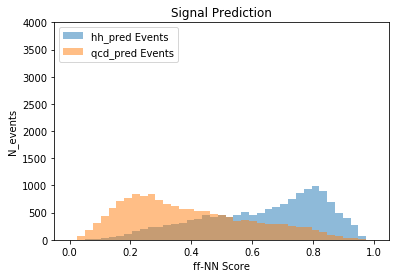

In [79]:
_nBins = 40
predictionResults = {'hh_pred':pred_hh, 'qcd_pred':pred_qcd}
compareManyHistograms( predictionResults, ['hh_pred', 'qcd_pred'], 2, 'Signal Prediction', 'ff-NN Score', 0, 1, _nBins, _savePlot=False )


In [80]:
# *** 4. Get best cut value for ff-NN assuming some minimal amount of signal
returnBestCutValue('ff-NN', pred_hh.copy(), pred_qcd.copy(), _minBackground=200)

14592 14584
nSig = [803.3032633] , nBkg = [3996000] with significance = [0.40185261] for ff-NN score > [0.7132666]


(array([0.40185261]), array([0.7132666], dtype=float32))

In [81]:
# *** 5. Get signifiance for any user-specified NN score cut value
cut = 0.81
_nSignal = sum( value > cut for value in pred_hh)*lumiScale_hh_to_qcd*totalLumi_HLLHC
_nBackground = sum( value > cut for value in pred_qcd)*totalLumi_HLLHC

print('nSig = {0} , nBkg = {1} with significance = {2} for NN score > {3}'.format(_nSignal, _nBackground, _nSignal/np.sqrt(_nBackground), cut) )

nSig = [401.1575952] , nBkg = [1347000] with significance = [0.34564575] for NN score > 0.81


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


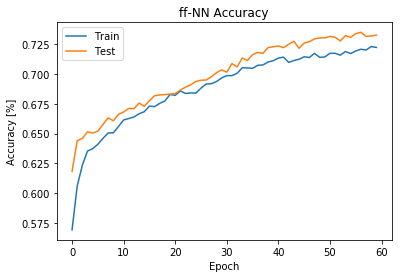

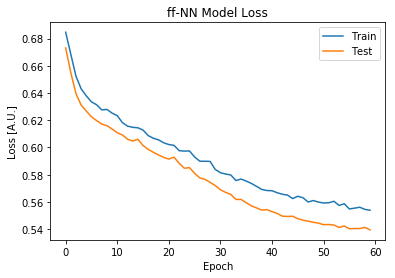

In [82]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ff-NN Accuracy')
plt.ylabel('Accuracy [%]')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ff-NN Model Loss')
plt.ylabel('Loss [A.U.]')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()